In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

In [212]:
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [213]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [214]:
test_new.shape #ROWS, COLUMNS

(25000, 4223)

In [215]:
multivariate_data=test_new.loc[500:24999,['dateTime','AEDATZ_HO_V0','AEWIHO_T9AV2','AEWIHOAVABV2','RWWIHOA_HWT0',
                                          'AEWIHOAKZ_V0','RWWIHOA_MWT0','AEDAHO_T9_V2']]
multivariate_data = multivariate_data.set_index('dateTime')
multivariate_data=multivariate_data.loc[::-1]
univariate_data=test_new.loc[500:24999,['dateTime','AEDAHO_T9_V2']]
univariate_data = univariate_data.set_index('dateTime')
univariate_data=univariate_data.loc[::-1]

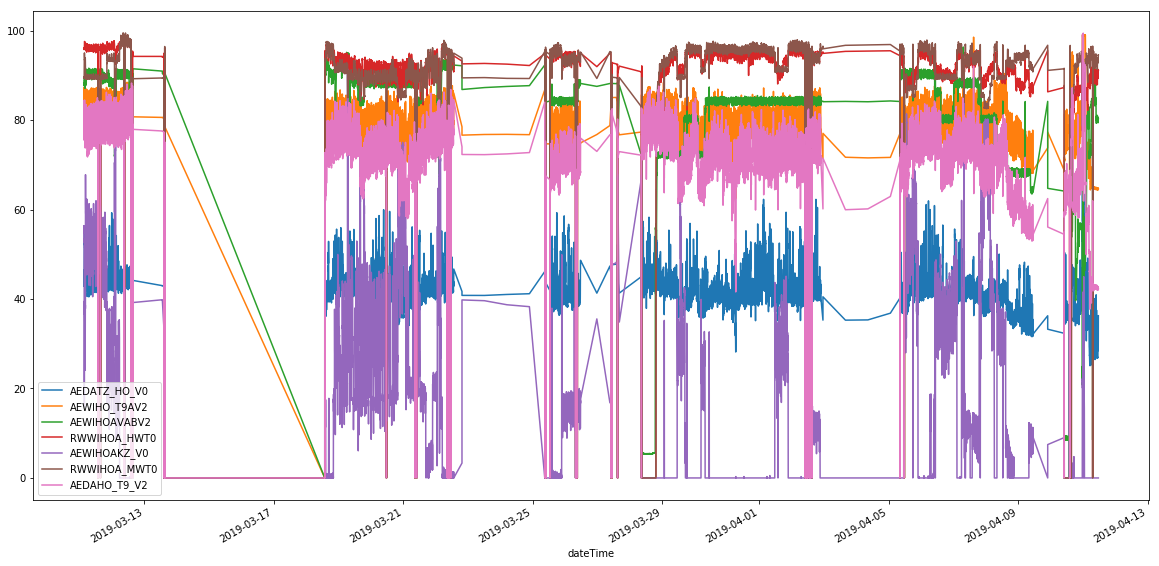

In [216]:
multivariate_data.plot()
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [54]:
# remove this line if you want do not want to count mean. Just comment it and uncomment the below lines.
multi_mean=multivariate_data.mean()
multivariate_data_mean= multivariate_data.replace(0,multi_mean)

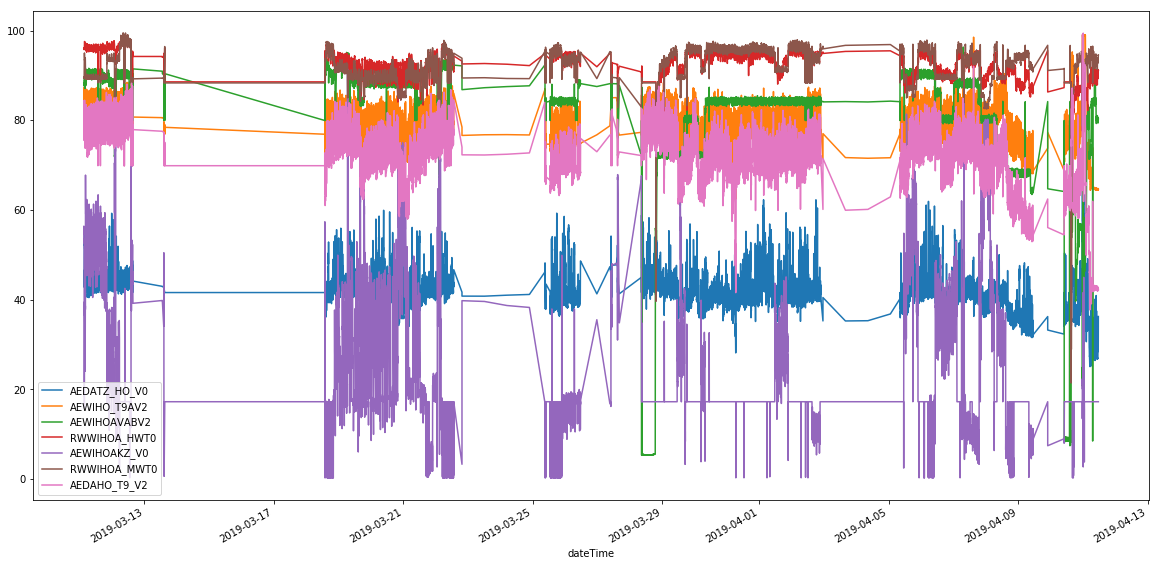

In [55]:
multivariate_data_mean.plot()
plt.show()

# train and test dataset making

In [106]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(multivariate_data_mean)
col_label=['AEDATZ_HO_V0','AEWIHO_T9AV2','AEWIHOAVABV2','RWWIHOA_HWT0','AEWIHOAKZ_V0','RWWIHOA_MWT0','AEDAHO_T9_V2']
df_normalized = pd.DataFrame(np_scaled,index=multivariate_data.index,columns=col_label)

In [67]:
# dataset=np.array(multivariate_data_mean)
dataset=np.array(df_normalized)

NumberOfElements=int(len(dataset)*0.9)
print('Number of Elements for training: ',NumberOfElements)
print('dataset length: ',len(dataset))

multiple_ip_train_data=dataset[0:NumberOfElements]
print(multiple_ip_train_data.shape)
multiple_ip_test_set=dataset[NumberOfElements:len(dataset)]
print(multiple_ip_test_set.shape)

Number of Elements for training:  22050
dataset length:  24500
(22050, 7)
(2450, 7)


In [68]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_1 = 4
# split into samples
X_Conv_Lstm, y_Conv_Lstm = split_sequence(multiple_ip_train_data, n_steps_1)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = X_Conv_Lstm.shape[2]
n_seq = 2
n_steps_2 = 2
# X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, 1, n_steps_2, n_features))

In [69]:
X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, 1, n_steps_2, n_features))

In [70]:
print(X_Conv_Lstm.size)
print(X_Conv_Lstm.shape)
print(X_Conv_Lstm.shape[0])
print(X_Conv_Lstm.shape[2])

529104
(22046, 4, 6)
22046
6


In [71]:
# define model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

lr = 0.01

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size=32
epochs=10

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_2, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_Conv_Lstm_train, y_Conv_Lstm, batch_size=batch_size, epochs=epochs,validation_split=0.2, verbose=1,
         callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/forecasting_sensor_data_Salzgitter_AG/trained_model_file/conv_LSTM_100.h5', save_best_only=True)])

Train on 17636 samples, validate on 4410 samples
Epoch 1/10
17636/17636 [==============================] - 5s 266us/step - loss: 0.0057 - val_loss: 0.0031
Epoch 2/10
17636/17636 [==============================] - 2s 133us/step - loss: 0.0033 - val_loss: 0.0044
Epoch 3/10
17636/17636 [==============================] - 2s 133us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
17636/17636 [==============================] - 3s 146us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/10
17636/17636 [==============================] - 3s 142us/step - loss: 0.0023 - val_loss: 0.0041
Epoch 6/10
17636/17636 [==============================] - 2s 134us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/10
17636/17636 [==============================] - 2s 136us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 8/10
17636/17636 [==============================] - 2s 137us/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/10
17636/17636 [==============================] - 2s 136us/step - loss: 0.0020 - val_loss: 0.00

In [72]:
X_Conv_Lstm_test, y_Conv_Lstm_test = split_sequence(multiple_ip_test_set, n_steps_1)

x_input = X_Conv_Lstm_test.reshape((X_Conv_Lstm_test.shape[0], n_seq, 1, n_steps_2, X_Conv_Lstm_test.shape[2]))
yhat = model.predict(x_input, verbose=1)
print(yhat)

2446/2446 [==============================] - 0s 155us/step
[[0.3492557 ]
 [0.33720744]
 [0.3402214 ]
 ...
 [0.16729575]
 [0.22320628]
 [0.27940613]]


In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Print MSE to see how good the model is
Error = mean_squared_error(y_Conv_Lstm_test,yhat)
print('mean squared error: ',Error)
print('RMSE Error: ',sqrt(Error))

mean squared error:  0.008328398856411208
RMSE Error:  0.09126006167218609


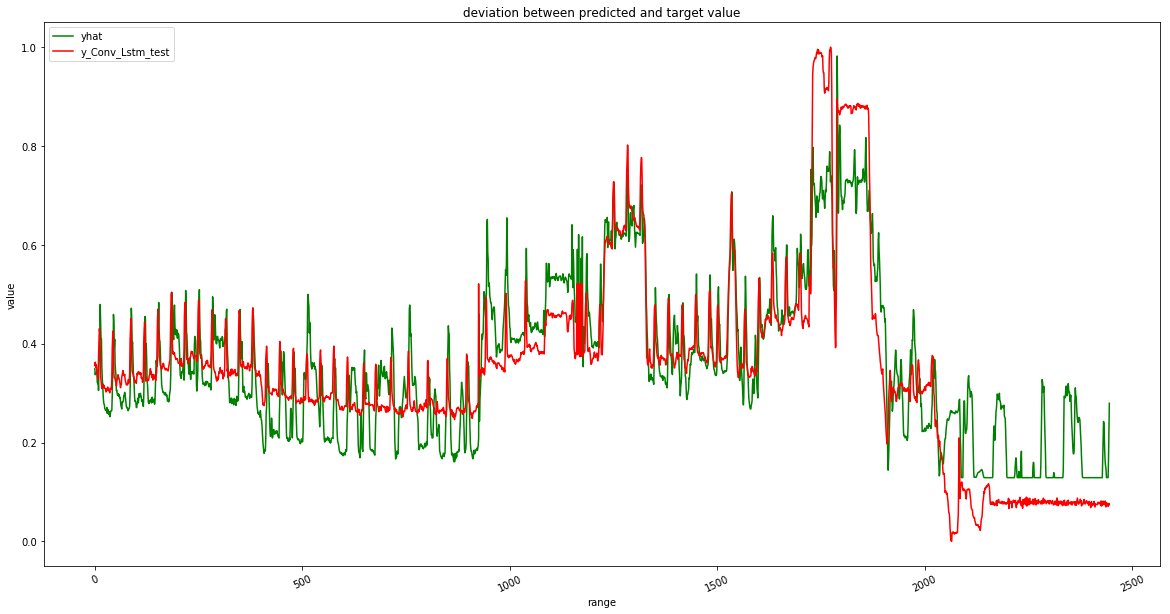

In [74]:
# my_data_1.index[0:-1]
plt.plot(yhat,color='green')
plt.plot(y_Conv_Lstm_test,color='red')
plt.xticks( rotation=25)
plt.title('deviation between predicted and target value')
plt.ylabel('value')
plt.xlabel('range')
plt.legend(['yhat', 'y_Conv_Lstm_test'], loc='upper left')
plt.show()

In [89]:
count=0
for i,j in multivariate_data.iterrows():
    for o in j:
        if o==0:
            print(count,'\t',i,'\t',o)
            count+=1
    

0 	 2019-03-11 13:43:00 	 0.0
1 	 2019-03-11 13:43:00 	 0.0
2 	 2019-03-11 13:45:00 	 0.0
3 	 2019-03-11 13:45:00 	 0.0
4 	 2019-03-11 13:45:00 	 0.0
5 	 2019-03-11 13:45:00 	 0.0
6 	 2019-03-11 13:46:00 	 0.0
7 	 2019-03-11 13:46:00 	 0.0
8 	 2019-03-11 15:33:00 	 0.0
9 	 2019-03-11 15:33:00 	 0.0
10 	 2019-03-11 15:35:00 	 0.0
11 	 2019-03-11 15:35:00 	 0.0
12 	 2019-03-11 15:35:00 	 0.0
13 	 2019-03-11 15:35:00 	 0.0
14 	 2019-03-11 15:36:00 	 0.0
15 	 2019-03-11 15:36:00 	 0.0
16 	 2019-03-12 05:42:00 	 0.0
17 	 2019-03-12 05:43:00 	 0.0
18 	 2019-03-12 05:44:00 	 0.0
19 	 2019-03-12 05:45:00 	 0.0
20 	 2019-03-12 05:46:00 	 0.0
21 	 2019-03-12 05:47:00 	 0.0
22 	 2019-03-12 05:48:00 	 0.0
23 	 2019-03-12 05:49:00 	 0.0
24 	 2019-03-12 05:50:00 	 0.0
25 	 2019-03-12 05:51:00 	 0.0
26 	 2019-03-12 05:52:00 	 0.0
27 	 2019-03-12 05:53:00 	 0.0
28 	 2019-03-12 05:54:00 	 0.0
29 	 2019-03-12 05:55:00 	 0.0
30 	 2019-03-12 05:56:00 	 0.0
31 	 2019-03-12 05:57:00 	 0.0
32 	 2019-03-12 05

482 	 2019-03-12 13:02:00 	 0.0
483 	 2019-03-12 13:03:00 	 0.0
484 	 2019-03-12 13:04:00 	 0.0
485 	 2019-03-12 13:05:00 	 0.0
486 	 2019-03-12 13:06:00 	 0.0
487 	 2019-03-12 13:07:00 	 0.0
488 	 2019-03-12 13:08:00 	 0.0
489 	 2019-03-12 13:09:00 	 0.0
490 	 2019-03-12 13:10:00 	 0.0
491 	 2019-03-12 13:11:00 	 0.0
492 	 2019-03-12 13:12:00 	 0.0
493 	 2019-03-12 13:13:00 	 0.0
494 	 2019-03-12 13:14:00 	 0.0
495 	 2019-03-12 13:16:00 	 0.0
496 	 2019-03-12 13:17:00 	 0.0
497 	 2019-03-12 13:18:00 	 0.0
498 	 2019-03-12 13:19:00 	 0.0
499 	 2019-03-12 13:20:00 	 0.0
500 	 2019-03-12 13:21:00 	 0.0
501 	 2019-03-12 13:22:00 	 0.0
502 	 2019-03-12 13:23:00 	 0.0
503 	 2019-03-12 13:24:00 	 0.0
504 	 2019-03-12 13:25:00 	 0.0
505 	 2019-03-12 13:26:00 	 0.0
506 	 2019-03-12 13:27:00 	 0.0
507 	 2019-03-12 13:28:00 	 0.0
508 	 2019-03-12 13:29:00 	 0.0
509 	 2019-03-12 13:30:00 	 0.0
510 	 2019-03-12 13:31:00 	 0.0
511 	 2019-03-12 13:32:00 	 0.0
512 	 2019-03-12 13:33:00 	 0.0
513 	 20

881 	 2019-03-18 19:07:00 	 0.0
882 	 2019-03-18 19:09:00 	 0.0
883 	 2019-03-18 19:11:00 	 0.0
884 	 2019-03-18 19:12:00 	 0.0
885 	 2019-03-18 19:13:00 	 0.0
886 	 2019-03-18 19:14:00 	 0.0
887 	 2019-03-18 19:15:00 	 0.0
888 	 2019-03-18 19:16:00 	 0.0
889 	 2019-03-18 19:17:00 	 0.0
890 	 2019-03-18 19:18:00 	 0.0
891 	 2019-03-18 19:19:00 	 0.0
892 	 2019-03-18 19:20:00 	 0.0
893 	 2019-03-18 19:21:00 	 0.0
894 	 2019-03-18 19:22:00 	 0.0
895 	 2019-03-18 19:23:00 	 0.0
896 	 2019-03-18 19:24:00 	 0.0
897 	 2019-03-18 19:25:00 	 0.0
898 	 2019-03-18 19:26:00 	 0.0
899 	 2019-03-18 19:27:00 	 0.0
900 	 2019-03-18 19:28:00 	 0.0
901 	 2019-03-18 19:29:00 	 0.0
902 	 2019-03-18 19:30:00 	 0.0
903 	 2019-03-18 19:31:00 	 0.0
904 	 2019-03-18 19:32:00 	 0.0
905 	 2019-03-18 19:33:00 	 0.0
906 	 2019-03-18 19:34:00 	 0.0
907 	 2019-03-18 19:35:00 	 0.0
908 	 2019-03-18 19:36:00 	 0.0
909 	 2019-03-18 19:38:00 	 0.0
910 	 2019-03-18 19:39:00 	 0.0
911 	 2019-03-18 19:40:00 	 0.0
912 	 20

1581 	 2019-03-25 15:35:00 	 0.0
1582 	 2019-03-25 15:36:00 	 0.0
1583 	 2019-03-25 15:37:00 	 0.0
1584 	 2019-03-25 15:38:00 	 0.0
1585 	 2019-03-25 15:39:00 	 0.0
1586 	 2019-03-25 15:40:00 	 0.0
1587 	 2019-03-25 15:41:00 	 0.0
1588 	 2019-03-25 15:42:00 	 0.0
1589 	 2019-03-25 15:43:00 	 0.0
1590 	 2019-03-25 15:44:00 	 0.0
1591 	 2019-03-25 15:45:00 	 0.0
1592 	 2019-03-25 15:46:00 	 0.0
1593 	 2019-03-25 15:47:00 	 0.0
1594 	 2019-03-25 15:48:00 	 0.0
1595 	 2019-03-25 15:49:00 	 0.0
1596 	 2019-03-25 15:50:00 	 0.0
1597 	 2019-03-25 15:52:00 	 0.0
1598 	 2019-03-25 15:53:00 	 0.0
1599 	 2019-03-25 15:54:00 	 0.0
1600 	 2019-03-25 15:55:00 	 0.0
1601 	 2019-03-25 15:56:00 	 0.0
1602 	 2019-03-25 15:57:00 	 0.0
1603 	 2019-03-25 15:58:00 	 0.0
1604 	 2019-03-25 15:59:00 	 0.0
1605 	 2019-03-25 16:00:00 	 0.0
1606 	 2019-03-25 16:01:00 	 0.0
1607 	 2019-03-25 16:02:00 	 0.0
1608 	 2019-03-25 16:03:00 	 0.0
1609 	 2019-03-25 16:05:00 	 0.0
1610 	 2019-03-25 16:06:00 	 0.0
1611 	 201

2081 	 2019-03-28 09:30:00 	 0.0
2082 	 2019-03-28 09:31:00 	 0.0
2083 	 2019-03-28 09:31:00 	 0.0
2084 	 2019-03-28 09:31:00 	 0.0
2085 	 2019-03-28 09:32:00 	 0.0
2086 	 2019-03-28 09:32:00 	 0.0
2087 	 2019-03-28 09:32:00 	 0.0
2088 	 2019-03-28 09:33:00 	 0.0
2089 	 2019-03-28 09:33:00 	 0.0
2090 	 2019-03-28 09:33:00 	 0.0
2091 	 2019-03-28 09:34:00 	 0.0
2092 	 2019-03-28 09:34:00 	 0.0
2093 	 2019-03-28 09:34:00 	 0.0
2094 	 2019-03-28 09:35:00 	 0.0
2095 	 2019-03-28 09:35:00 	 0.0
2096 	 2019-03-28 09:35:00 	 0.0
2097 	 2019-03-28 09:36:00 	 0.0
2098 	 2019-03-28 09:36:00 	 0.0
2099 	 2019-03-28 09:36:00 	 0.0
2100 	 2019-03-28 09:37:00 	 0.0
2101 	 2019-03-28 09:37:00 	 0.0
2102 	 2019-03-28 09:37:00 	 0.0
2103 	 2019-03-28 09:38:00 	 0.0
2104 	 2019-03-28 09:38:00 	 0.0
2105 	 2019-03-28 09:38:00 	 0.0
2106 	 2019-03-28 09:39:00 	 0.0
2107 	 2019-03-28 09:39:00 	 0.0
2108 	 2019-03-28 09:39:00 	 0.0
2109 	 2019-03-28 09:40:00 	 0.0
2110 	 2019-03-28 09:40:00 	 0.0
2111 	 201

2681 	 2019-03-28 12:50:00 	 0.0
2682 	 2019-03-28 12:51:00 	 0.0
2683 	 2019-03-28 12:51:00 	 0.0
2684 	 2019-03-28 12:51:00 	 0.0
2685 	 2019-03-28 12:52:00 	 0.0
2686 	 2019-03-28 12:52:00 	 0.0
2687 	 2019-03-28 12:52:00 	 0.0
2688 	 2019-03-28 12:53:00 	 0.0
2689 	 2019-03-28 12:53:00 	 0.0
2690 	 2019-03-28 12:53:00 	 0.0
2691 	 2019-03-28 12:54:00 	 0.0
2692 	 2019-03-28 12:54:00 	 0.0
2693 	 2019-03-28 12:54:00 	 0.0
2694 	 2019-03-28 12:55:00 	 0.0
2695 	 2019-03-28 12:55:00 	 0.0
2696 	 2019-03-28 12:55:00 	 0.0
2697 	 2019-03-28 12:56:00 	 0.0
2698 	 2019-03-28 12:56:00 	 0.0
2699 	 2019-03-28 12:56:00 	 0.0
2700 	 2019-03-28 12:57:00 	 0.0
2701 	 2019-03-28 12:57:00 	 0.0
2702 	 2019-03-28 12:57:00 	 0.0
2703 	 2019-03-28 12:58:00 	 0.0
2704 	 2019-03-28 12:58:00 	 0.0
2705 	 2019-03-28 12:58:00 	 0.0
2706 	 2019-03-28 12:59:00 	 0.0
2707 	 2019-03-28 12:59:00 	 0.0
2708 	 2019-03-28 12:59:00 	 0.0
2709 	 2019-03-28 13:00:00 	 0.0
2710 	 2019-03-28 13:00:00 	 0.0
2711 	 201

3281 	 2019-03-28 16:10:00 	 0.0
3282 	 2019-03-28 16:11:00 	 0.0
3283 	 2019-03-28 16:11:00 	 0.0
3284 	 2019-03-28 16:11:00 	 0.0
3285 	 2019-03-28 16:12:00 	 0.0
3286 	 2019-03-28 16:12:00 	 0.0
3287 	 2019-03-28 16:12:00 	 0.0
3288 	 2019-03-28 16:13:00 	 0.0
3289 	 2019-03-28 16:13:00 	 0.0
3290 	 2019-03-28 16:13:00 	 0.0
3291 	 2019-03-28 16:14:00 	 0.0
3292 	 2019-03-28 16:14:00 	 0.0
3293 	 2019-03-28 16:14:00 	 0.0
3294 	 2019-03-28 16:15:00 	 0.0
3295 	 2019-03-28 16:15:00 	 0.0
3296 	 2019-03-28 16:15:00 	 0.0
3297 	 2019-03-28 16:16:00 	 0.0
3298 	 2019-03-28 16:16:00 	 0.0
3299 	 2019-03-28 16:16:00 	 0.0
3300 	 2019-03-28 16:17:00 	 0.0
3301 	 2019-03-28 16:17:00 	 0.0
3302 	 2019-03-28 16:17:00 	 0.0
3303 	 2019-03-28 16:18:00 	 0.0
3304 	 2019-03-28 16:18:00 	 0.0
3305 	 2019-03-28 16:18:00 	 0.0
3306 	 2019-03-28 16:19:00 	 0.0
3307 	 2019-03-28 16:19:00 	 0.0
3308 	 2019-03-28 16:19:00 	 0.0
3309 	 2019-03-28 16:20:00 	 0.0
3310 	 2019-03-28 16:20:00 	 0.0
3311 	 201

3981 	 2019-03-28 21:12:00 	 0.0
3982 	 2019-03-28 21:13:00 	 0.0
3983 	 2019-03-28 21:14:00 	 0.0
3984 	 2019-03-28 21:15:00 	 0.0
3985 	 2019-03-28 21:16:00 	 0.0
3986 	 2019-03-28 21:17:00 	 0.0
3987 	 2019-03-28 21:18:00 	 0.0
3988 	 2019-03-28 21:19:00 	 0.0
3989 	 2019-03-28 21:20:00 	 0.0
3990 	 2019-03-28 21:21:00 	 0.0
3991 	 2019-03-28 21:22:00 	 0.0
3992 	 2019-03-28 21:23:00 	 0.0
3993 	 2019-03-28 21:24:00 	 0.0
3994 	 2019-03-28 21:25:00 	 0.0
3995 	 2019-03-28 21:26:00 	 0.0
3996 	 2019-03-28 21:27:00 	 0.0
3997 	 2019-03-28 21:28:00 	 0.0
3998 	 2019-03-28 21:29:00 	 0.0
3999 	 2019-03-28 21:30:00 	 0.0
4000 	 2019-03-28 21:31:00 	 0.0
4001 	 2019-03-28 21:32:00 	 0.0
4002 	 2019-03-28 21:33:00 	 0.0
4003 	 2019-03-28 21:34:00 	 0.0
4004 	 2019-03-28 21:35:00 	 0.0
4005 	 2019-03-28 21:36:00 	 0.0
4006 	 2019-03-28 21:37:00 	 0.0
4007 	 2019-03-28 21:38:00 	 0.0
4008 	 2019-03-28 21:39:00 	 0.0
4009 	 2019-03-28 21:40:00 	 0.0
4010 	 2019-03-28 21:41:00 	 0.0
4011 	 201

4481 	 2019-03-29 05:32:00 	 0.0
4482 	 2019-03-29 05:33:00 	 0.0
4483 	 2019-03-29 05:34:00 	 0.0
4484 	 2019-03-29 05:35:00 	 0.0
4485 	 2019-03-29 05:36:00 	 0.0
4486 	 2019-03-29 05:37:00 	 0.0
4487 	 2019-03-29 05:38:00 	 0.0
4488 	 2019-03-29 05:39:00 	 0.0
4489 	 2019-03-29 05:40:00 	 0.0
4490 	 2019-03-29 05:41:00 	 0.0
4491 	 2019-03-29 05:42:00 	 0.0
4492 	 2019-03-29 05:43:00 	 0.0
4493 	 2019-03-29 05:44:00 	 0.0
4494 	 2019-03-29 05:45:00 	 0.0
4495 	 2019-03-29 05:46:00 	 0.0
4496 	 2019-03-29 05:47:00 	 0.0
4497 	 2019-03-29 05:48:00 	 0.0
4498 	 2019-03-29 05:49:00 	 0.0
4499 	 2019-03-29 05:50:00 	 0.0
4500 	 2019-03-29 05:51:00 	 0.0
4501 	 2019-03-29 05:52:00 	 0.0
4502 	 2019-03-29 05:53:00 	 0.0
4503 	 2019-03-29 05:54:00 	 0.0
4504 	 2019-03-29 05:55:00 	 0.0
4505 	 2019-03-29 05:56:00 	 0.0
4506 	 2019-03-29 05:57:00 	 0.0
4507 	 2019-03-29 05:58:00 	 0.0
4508 	 2019-03-29 05:59:00 	 0.0
4509 	 2019-03-29 06:00:00 	 0.0
4510 	 2019-03-29 06:01:00 	 0.0
4511 	 201

4981 	 2019-03-29 19:56:00 	 0.0
4982 	 2019-03-29 19:57:00 	 0.0
4983 	 2019-03-29 19:58:00 	 0.0
4984 	 2019-03-29 19:59:00 	 0.0
4985 	 2019-03-29 20:00:00 	 0.0
4986 	 2019-03-29 20:01:00 	 0.0
4987 	 2019-03-29 20:02:00 	 0.0
4988 	 2019-03-29 20:03:00 	 0.0
4989 	 2019-03-29 20:04:00 	 0.0
4990 	 2019-03-29 20:05:00 	 0.0
4991 	 2019-03-29 20:06:00 	 0.0
4992 	 2019-03-29 20:07:00 	 0.0
4993 	 2019-03-29 20:08:00 	 0.0
4994 	 2019-03-29 20:09:00 	 0.0
4995 	 2019-03-29 20:10:00 	 0.0
4996 	 2019-03-29 20:11:00 	 0.0
4997 	 2019-03-29 20:12:00 	 0.0
4998 	 2019-03-29 20:13:00 	 0.0
4999 	 2019-03-29 20:14:00 	 0.0
5000 	 2019-03-29 20:15:00 	 0.0
5001 	 2019-03-29 20:16:00 	 0.0
5002 	 2019-03-29 20:17:00 	 0.0
5003 	 2019-03-29 20:18:00 	 0.0
5004 	 2019-03-29 20:19:00 	 0.0
5005 	 2019-03-29 20:20:00 	 0.0
5006 	 2019-03-29 20:21:00 	 0.0
5007 	 2019-03-29 20:22:00 	 0.0
5008 	 2019-03-29 20:23:00 	 0.0
5009 	 2019-03-29 20:24:00 	 0.0
5010 	 2019-03-29 20:25:00 	 0.0
5011 	 201

5581 	 2019-03-30 08:55:00 	 0.0
5582 	 2019-03-30 08:56:00 	 0.0
5583 	 2019-03-30 08:57:00 	 0.0
5584 	 2019-03-30 08:58:00 	 0.0
5585 	 2019-03-30 08:59:00 	 0.0
5586 	 2019-03-30 09:00:00 	 0.0
5587 	 2019-03-30 09:01:00 	 0.0
5588 	 2019-03-30 09:02:00 	 0.0
5589 	 2019-03-30 09:03:00 	 0.0
5590 	 2019-03-30 09:04:00 	 0.0
5591 	 2019-03-30 09:05:00 	 0.0
5592 	 2019-03-30 09:06:00 	 0.0
5593 	 2019-03-30 09:07:00 	 0.0
5594 	 2019-03-30 09:08:00 	 0.0
5595 	 2019-03-30 09:09:00 	 0.0
5596 	 2019-03-30 09:10:00 	 0.0
5597 	 2019-03-30 09:11:00 	 0.0
5598 	 2019-03-30 09:12:00 	 0.0
5599 	 2019-03-30 09:13:00 	 0.0
5600 	 2019-03-30 09:14:00 	 0.0
5601 	 2019-03-30 09:15:00 	 0.0
5602 	 2019-03-30 09:16:00 	 0.0
5603 	 2019-03-30 09:17:00 	 0.0
5604 	 2019-03-30 09:18:00 	 0.0
5605 	 2019-03-30 09:19:00 	 0.0
5606 	 2019-03-30 09:20:00 	 0.0
5607 	 2019-03-30 09:21:00 	 0.0
5608 	 2019-03-30 09:22:00 	 0.0
5609 	 2019-03-30 09:23:00 	 0.0
5610 	 2019-03-30 09:24:00 	 0.0
5611 	 201

6180 	 2019-03-30 18:54:00 	 0.0
6181 	 2019-03-30 18:55:00 	 0.0
6182 	 2019-03-30 18:56:00 	 0.0
6183 	 2019-03-30 18:57:00 	 0.0
6184 	 2019-03-30 18:58:00 	 0.0
6185 	 2019-03-30 18:59:00 	 0.0
6186 	 2019-03-30 19:00:00 	 0.0
6187 	 2019-03-30 19:01:00 	 0.0
6188 	 2019-03-30 19:02:00 	 0.0
6189 	 2019-03-30 19:03:00 	 0.0
6190 	 2019-03-30 19:04:00 	 0.0
6191 	 2019-03-30 19:05:00 	 0.0
6192 	 2019-03-30 19:06:00 	 0.0
6193 	 2019-03-30 19:07:00 	 0.0
6194 	 2019-03-30 19:08:00 	 0.0
6195 	 2019-03-30 19:09:00 	 0.0
6196 	 2019-03-30 19:10:00 	 0.0
6197 	 2019-03-30 19:11:00 	 0.0
6198 	 2019-03-30 19:12:00 	 0.0
6199 	 2019-03-30 19:13:00 	 0.0
6200 	 2019-03-30 19:14:00 	 0.0
6201 	 2019-03-30 19:15:00 	 0.0
6202 	 2019-03-30 19:16:00 	 0.0
6203 	 2019-03-30 19:17:00 	 0.0
6204 	 2019-03-30 19:18:00 	 0.0
6205 	 2019-03-30 19:19:00 	 0.0
6206 	 2019-03-30 19:20:00 	 0.0
6207 	 2019-03-30 19:21:00 	 0.0
6208 	 2019-03-30 19:22:00 	 0.0
6209 	 2019-03-30 19:23:00 	 0.0
6210 	 201

6658 	 2019-03-31 03:52:00 	 0.0
6659 	 2019-03-31 03:53:00 	 0.0
6660 	 2019-03-31 03:54:00 	 0.0
6661 	 2019-03-31 03:55:00 	 0.0
6662 	 2019-03-31 03:56:00 	 0.0
6663 	 2019-03-31 03:57:00 	 0.0
6664 	 2019-03-31 03:58:00 	 0.0
6665 	 2019-03-31 03:59:00 	 0.0
6666 	 2019-03-31 04:00:00 	 0.0
6667 	 2019-03-31 04:01:00 	 0.0
6668 	 2019-03-31 04:02:00 	 0.0
6669 	 2019-03-31 04:03:00 	 0.0
6670 	 2019-03-31 04:04:00 	 0.0
6671 	 2019-03-31 04:05:00 	 0.0
6672 	 2019-03-31 04:06:00 	 0.0
6673 	 2019-03-31 04:07:00 	 0.0
6674 	 2019-03-31 04:08:00 	 0.0
6675 	 2019-03-31 04:09:00 	 0.0
6676 	 2019-03-31 04:10:00 	 0.0
6677 	 2019-03-31 04:11:00 	 0.0
6678 	 2019-03-31 04:12:00 	 0.0
6679 	 2019-03-31 04:13:00 	 0.0
6680 	 2019-03-31 04:14:00 	 0.0
6681 	 2019-03-31 04:15:00 	 0.0
6682 	 2019-03-31 04:16:00 	 0.0
6683 	 2019-03-31 04:17:00 	 0.0
6684 	 2019-03-31 04:18:00 	 0.0
6685 	 2019-03-31 04:19:00 	 0.0
6686 	 2019-03-31 04:20:00 	 0.0
6687 	 2019-03-31 04:21:00 	 0.0
6688 	 201

7480 	 2019-03-31 17:36:00 	 0.0
7481 	 2019-03-31 17:37:00 	 0.0
7482 	 2019-03-31 17:38:00 	 0.0
7483 	 2019-03-31 17:39:00 	 0.0
7484 	 2019-03-31 17:40:00 	 0.0
7485 	 2019-03-31 17:41:00 	 0.0
7486 	 2019-03-31 17:42:00 	 0.0
7487 	 2019-03-31 17:43:00 	 0.0
7488 	 2019-03-31 17:44:00 	 0.0
7489 	 2019-03-31 17:45:00 	 0.0
7490 	 2019-03-31 17:46:00 	 0.0
7491 	 2019-03-31 17:47:00 	 0.0
7492 	 2019-03-31 17:48:00 	 0.0
7493 	 2019-03-31 17:49:00 	 0.0
7494 	 2019-03-31 17:50:00 	 0.0
7495 	 2019-03-31 17:51:00 	 0.0
7496 	 2019-03-31 17:52:00 	 0.0
7497 	 2019-03-31 17:53:00 	 0.0
7498 	 2019-03-31 17:54:00 	 0.0
7499 	 2019-03-31 17:55:00 	 0.0
7500 	 2019-03-31 17:56:00 	 0.0
7501 	 2019-03-31 17:57:00 	 0.0
7502 	 2019-03-31 17:58:00 	 0.0
7503 	 2019-03-31 17:59:00 	 0.0
7504 	 2019-03-31 18:00:00 	 0.0
7505 	 2019-03-31 18:01:00 	 0.0
7506 	 2019-03-31 18:02:00 	 0.0
7507 	 2019-03-31 18:03:00 	 0.0
7508 	 2019-03-31 18:04:00 	 0.0
7509 	 2019-03-31 18:05:00 	 0.0
7510 	 201

8080 	 2019-04-01 03:36:00 	 0.0
8081 	 2019-04-01 03:37:00 	 0.0
8082 	 2019-04-01 03:38:00 	 0.0
8083 	 2019-04-01 03:39:00 	 0.0
8084 	 2019-04-01 03:40:00 	 0.0
8085 	 2019-04-01 03:41:00 	 0.0
8086 	 2019-04-01 03:42:00 	 0.0
8087 	 2019-04-01 03:43:00 	 0.0
8088 	 2019-04-01 03:44:00 	 0.0
8089 	 2019-04-01 03:45:00 	 0.0
8090 	 2019-04-01 03:46:00 	 0.0
8091 	 2019-04-01 03:47:00 	 0.0
8092 	 2019-04-01 03:48:00 	 0.0
8093 	 2019-04-01 03:49:00 	 0.0
8094 	 2019-04-01 03:50:00 	 0.0
8095 	 2019-04-01 03:51:00 	 0.0
8096 	 2019-04-01 03:52:00 	 0.0
8097 	 2019-04-01 03:53:00 	 0.0
8098 	 2019-04-01 03:54:00 	 0.0
8099 	 2019-04-01 03:55:00 	 0.0
8100 	 2019-04-01 03:56:00 	 0.0
8101 	 2019-04-01 03:57:00 	 0.0
8102 	 2019-04-01 03:58:00 	 0.0
8103 	 2019-04-01 03:59:00 	 0.0
8104 	 2019-04-01 04:00:00 	 0.0
8105 	 2019-04-01 04:01:00 	 0.0
8106 	 2019-04-01 04:02:00 	 0.0
8107 	 2019-04-01 04:03:00 	 0.0
8108 	 2019-04-01 04:04:00 	 0.0
8109 	 2019-04-01 04:05:00 	 0.0
8110 	 201

8580 	 2019-04-01 21:54:00 	 0.0
8581 	 2019-04-01 21:55:00 	 0.0
8582 	 2019-04-01 21:56:00 	 0.0
8583 	 2019-04-01 21:57:00 	 0.0
8584 	 2019-04-01 21:58:00 	 0.0
8585 	 2019-04-01 21:59:00 	 0.0
8586 	 2019-04-01 22:00:00 	 0.0
8587 	 2019-04-01 22:01:00 	 0.0
8588 	 2019-04-01 22:02:00 	 0.0
8589 	 2019-04-01 22:03:00 	 0.0
8590 	 2019-04-01 22:04:00 	 0.0
8591 	 2019-04-01 22:05:00 	 0.0
8592 	 2019-04-01 22:06:00 	 0.0
8593 	 2019-04-01 22:07:00 	 0.0
8594 	 2019-04-01 22:08:00 	 0.0
8595 	 2019-04-01 22:09:00 	 0.0
8596 	 2019-04-01 22:10:00 	 0.0
8597 	 2019-04-01 22:11:00 	 0.0
8598 	 2019-04-01 22:12:00 	 0.0
8599 	 2019-04-01 22:13:00 	 0.0
8600 	 2019-04-01 22:14:00 	 0.0
8601 	 2019-04-01 22:15:00 	 0.0
8602 	 2019-04-01 22:16:00 	 0.0
8603 	 2019-04-01 22:17:00 	 0.0
8604 	 2019-04-01 22:18:00 	 0.0
8605 	 2019-04-01 22:19:00 	 0.0
8606 	 2019-04-01 22:20:00 	 0.0
8607 	 2019-04-01 22:21:00 	 0.0
8608 	 2019-04-01 22:22:00 	 0.0
8609 	 2019-04-01 22:23:00 	 0.0
8610 	 201

9180 	 2019-04-02 07:55:00 	 0.0
9181 	 2019-04-02 07:56:00 	 0.0
9182 	 2019-04-02 07:57:00 	 0.0
9183 	 2019-04-02 07:58:00 	 0.0
9184 	 2019-04-02 07:59:00 	 0.0
9185 	 2019-04-02 08:00:00 	 0.0
9186 	 2019-04-02 08:01:00 	 0.0
9187 	 2019-04-02 08:02:00 	 0.0
9188 	 2019-04-02 08:03:00 	 0.0
9189 	 2019-04-02 08:04:00 	 0.0
9190 	 2019-04-02 08:05:00 	 0.0
9191 	 2019-04-02 08:06:00 	 0.0
9192 	 2019-04-02 08:07:00 	 0.0
9193 	 2019-04-02 08:08:00 	 0.0
9194 	 2019-04-02 08:09:00 	 0.0
9195 	 2019-04-02 08:10:00 	 0.0
9196 	 2019-04-02 08:11:00 	 0.0
9197 	 2019-04-02 08:12:00 	 0.0
9198 	 2019-04-02 08:13:00 	 0.0
9199 	 2019-04-02 08:14:00 	 0.0
9200 	 2019-04-02 08:15:00 	 0.0
9201 	 2019-04-02 08:16:00 	 0.0
9202 	 2019-04-02 08:17:00 	 0.0
9203 	 2019-04-02 08:18:00 	 0.0
9204 	 2019-04-02 08:19:00 	 0.0
9205 	 2019-04-02 08:20:00 	 0.0
9206 	 2019-04-02 08:21:00 	 0.0
9207 	 2019-04-02 08:22:00 	 0.0
9208 	 2019-04-02 08:23:00 	 0.0
9209 	 2019-04-02 08:24:00 	 0.0
9210 	 201

9680 	 2019-04-02 21:11:00 	 0.0
9681 	 2019-04-02 21:12:00 	 0.0
9682 	 2019-04-02 21:13:00 	 0.0
9683 	 2019-04-02 21:14:00 	 0.0
9684 	 2019-04-02 21:15:00 	 0.0
9685 	 2019-04-02 21:16:00 	 0.0
9686 	 2019-04-02 21:17:00 	 0.0
9687 	 2019-04-02 21:18:00 	 0.0
9688 	 2019-04-02 21:19:00 	 0.0
9689 	 2019-04-02 21:20:00 	 0.0
9690 	 2019-04-02 21:21:00 	 0.0
9691 	 2019-04-02 21:22:00 	 0.0
9692 	 2019-04-02 21:23:00 	 0.0
9693 	 2019-04-02 21:24:00 	 0.0
9694 	 2019-04-02 21:25:00 	 0.0
9695 	 2019-04-02 21:26:00 	 0.0
9696 	 2019-04-02 21:27:00 	 0.0
9697 	 2019-04-02 21:28:00 	 0.0
9698 	 2019-04-02 21:29:00 	 0.0
9699 	 2019-04-02 21:30:00 	 0.0
9700 	 2019-04-02 21:31:00 	 0.0
9701 	 2019-04-02 21:32:00 	 0.0
9702 	 2019-04-02 21:33:00 	 0.0
9703 	 2019-04-02 21:34:00 	 0.0
9704 	 2019-04-02 21:35:00 	 0.0
9705 	 2019-04-02 21:36:00 	 0.0
9706 	 2019-04-02 21:37:00 	 0.0
9707 	 2019-04-02 21:38:00 	 0.0
9708 	 2019-04-02 21:39:00 	 0.0
9709 	 2019-04-02 21:40:00 	 0.0
9710 	 201

10180 	 2019-04-06 02:17:00 	 0.0
10181 	 2019-04-06 02:18:00 	 0.0
10182 	 2019-04-06 02:19:00 	 0.0
10183 	 2019-04-06 02:20:00 	 0.0
10184 	 2019-04-06 02:22:00 	 0.0
10185 	 2019-04-06 02:23:00 	 0.0
10186 	 2019-04-06 02:25:00 	 0.0
10187 	 2019-04-06 02:26:00 	 0.0
10188 	 2019-04-06 02:27:00 	 0.0
10189 	 2019-04-06 02:28:00 	 0.0
10190 	 2019-04-06 02:29:00 	 0.0
10191 	 2019-04-06 02:30:00 	 0.0
10192 	 2019-04-06 02:32:00 	 0.0
10193 	 2019-04-06 02:33:00 	 0.0
10194 	 2019-04-06 02:34:00 	 0.0
10195 	 2019-04-06 02:35:00 	 0.0
10196 	 2019-04-06 02:36:00 	 0.0
10197 	 2019-04-06 02:37:00 	 0.0
10198 	 2019-04-06 02:38:00 	 0.0
10199 	 2019-04-06 02:39:00 	 0.0
10200 	 2019-04-06 02:40:00 	 0.0
10201 	 2019-04-06 02:41:00 	 0.0
10202 	 2019-04-06 02:42:00 	 0.0
10203 	 2019-04-06 02:43:00 	 0.0
10204 	 2019-04-06 02:44:00 	 0.0
10205 	 2019-04-06 02:45:00 	 0.0
10206 	 2019-04-06 02:46:00 	 0.0
10207 	 2019-04-06 02:47:00 	 0.0
10208 	 2019-04-06 02:48:00 	 0.0
10209 	 2019-0

10649 	 2019-04-07 04:34:00 	 0.0
10650 	 2019-04-07 04:35:00 	 0.0
10651 	 2019-04-07 04:36:00 	 0.0
10652 	 2019-04-07 04:37:00 	 0.0
10653 	 2019-04-07 04:38:00 	 0.0
10654 	 2019-04-07 04:39:00 	 0.0
10655 	 2019-04-07 04:40:00 	 0.0
10656 	 2019-04-07 04:41:00 	 0.0
10657 	 2019-04-07 04:42:00 	 0.0
10658 	 2019-04-07 04:43:00 	 0.0
10659 	 2019-04-07 04:44:00 	 0.0
10660 	 2019-04-07 04:45:00 	 0.0
10661 	 2019-04-07 04:46:00 	 0.0
10662 	 2019-04-07 04:47:00 	 0.0
10663 	 2019-04-07 04:48:00 	 0.0
10664 	 2019-04-07 04:49:00 	 0.0
10665 	 2019-04-07 04:50:00 	 0.0
10666 	 2019-04-07 04:51:00 	 0.0
10667 	 2019-04-07 04:52:00 	 0.0
10668 	 2019-04-07 04:53:00 	 0.0
10669 	 2019-04-07 04:54:00 	 0.0
10670 	 2019-04-07 04:55:00 	 0.0
10671 	 2019-04-07 04:56:00 	 0.0
10672 	 2019-04-07 04:57:00 	 0.0
10673 	 2019-04-07 04:58:00 	 0.0
10674 	 2019-04-07 04:59:00 	 0.0
10675 	 2019-04-07 05:00:00 	 0.0
10676 	 2019-04-07 05:02:00 	 0.0
10677 	 2019-04-07 05:03:00 	 0.0
10678 	 2019-0

10979 	 2019-04-08 16:07:00 	 0.0
10980 	 2019-04-08 16:08:00 	 0.0
10981 	 2019-04-08 16:09:00 	 0.0
10982 	 2019-04-08 16:10:00 	 0.0
10983 	 2019-04-08 16:11:00 	 0.0
10984 	 2019-04-08 16:12:00 	 0.0
10985 	 2019-04-08 16:13:00 	 0.0
10986 	 2019-04-08 16:14:00 	 0.0
10987 	 2019-04-08 16:15:00 	 0.0
10988 	 2019-04-08 16:16:00 	 0.0
10989 	 2019-04-08 16:17:00 	 0.0
10990 	 2019-04-08 16:18:00 	 0.0
10991 	 2019-04-08 16:19:00 	 0.0
10992 	 2019-04-08 16:20:00 	 0.0
10993 	 2019-04-08 16:21:00 	 0.0
10994 	 2019-04-08 16:22:00 	 0.0
10995 	 2019-04-08 16:23:00 	 0.0
10996 	 2019-04-08 16:24:00 	 0.0
10997 	 2019-04-08 16:25:00 	 0.0
10998 	 2019-04-08 16:26:00 	 0.0
10999 	 2019-04-08 16:27:00 	 0.0
11000 	 2019-04-08 16:28:00 	 0.0
11001 	 2019-04-08 16:29:00 	 0.0
11002 	 2019-04-08 16:30:00 	 0.0
11003 	 2019-04-08 16:31:00 	 0.0
11004 	 2019-04-08 16:32:00 	 0.0
11005 	 2019-04-08 16:33:00 	 0.0
11006 	 2019-04-08 16:34:00 	 0.0
11007 	 2019-04-08 16:35:00 	 0.0
11008 	 2019-0

11479 	 2019-04-09 04:03:00 	 0.0
11480 	 2019-04-09 04:04:00 	 0.0
11481 	 2019-04-09 04:05:00 	 0.0
11482 	 2019-04-09 04:06:00 	 0.0
11483 	 2019-04-09 04:07:00 	 0.0
11484 	 2019-04-09 04:08:00 	 0.0
11485 	 2019-04-09 04:09:00 	 0.0
11486 	 2019-04-09 04:10:00 	 0.0
11487 	 2019-04-09 04:11:00 	 0.0
11488 	 2019-04-09 04:12:00 	 0.0
11489 	 2019-04-09 04:13:00 	 0.0
11490 	 2019-04-09 04:14:00 	 0.0
11491 	 2019-04-09 04:15:00 	 0.0
11492 	 2019-04-09 04:16:00 	 0.0
11493 	 2019-04-09 04:17:00 	 0.0
11494 	 2019-04-09 04:18:00 	 0.0
11495 	 2019-04-09 04:19:00 	 0.0
11496 	 2019-04-09 04:20:00 	 0.0
11497 	 2019-04-09 04:21:00 	 0.0
11498 	 2019-04-09 04:22:00 	 0.0
11499 	 2019-04-09 04:23:00 	 0.0
11500 	 2019-04-09 04:24:00 	 0.0
11501 	 2019-04-09 04:25:00 	 0.0
11502 	 2019-04-09 04:26:00 	 0.0
11503 	 2019-04-09 04:27:00 	 0.0
11504 	 2019-04-09 04:28:00 	 0.0
11505 	 2019-04-09 04:29:00 	 0.0
11506 	 2019-04-09 04:30:00 	 0.0
11507 	 2019-04-09 04:31:00 	 0.0
11508 	 2019-0

12079 	 2019-04-10 12:12:00 	 0.0
12080 	 2019-04-10 12:12:00 	 0.0
12081 	 2019-04-10 12:12:00 	 0.0
12082 	 2019-04-10 12:13:00 	 0.0
12083 	 2019-04-10 12:13:00 	 0.0
12084 	 2019-04-10 12:13:00 	 0.0
12085 	 2019-04-10 12:14:00 	 0.0
12086 	 2019-04-10 12:14:00 	 0.0
12087 	 2019-04-10 12:14:00 	 0.0
12088 	 2019-04-10 12:15:00 	 0.0
12089 	 2019-04-10 12:15:00 	 0.0
12090 	 2019-04-10 12:15:00 	 0.0
12091 	 2019-04-10 12:16:00 	 0.0
12092 	 2019-04-10 12:16:00 	 0.0
12093 	 2019-04-10 12:16:00 	 0.0
12094 	 2019-04-10 12:17:00 	 0.0
12095 	 2019-04-10 12:17:00 	 0.0
12096 	 2019-04-10 12:17:00 	 0.0
12097 	 2019-04-10 12:18:00 	 0.0
12098 	 2019-04-10 12:18:00 	 0.0
12099 	 2019-04-10 12:18:00 	 0.0
12100 	 2019-04-10 12:19:00 	 0.0
12101 	 2019-04-10 12:19:00 	 0.0
12102 	 2019-04-10 12:19:00 	 0.0
12103 	 2019-04-10 12:20:00 	 0.0
12104 	 2019-04-10 12:20:00 	 0.0
12105 	 2019-04-10 12:20:00 	 0.0
12106 	 2019-04-10 12:21:00 	 0.0
12107 	 2019-04-10 12:21:00 	 0.0
12108 	 2019-0

12779 	 2019-04-10 17:35:00 	 0.0
12780 	 2019-04-10 17:36:00 	 0.0
12781 	 2019-04-10 17:37:00 	 0.0
12782 	 2019-04-10 17:38:00 	 0.0
12783 	 2019-04-10 17:39:00 	 0.0
12784 	 2019-04-10 17:40:00 	 0.0
12785 	 2019-04-10 17:41:00 	 0.0
12786 	 2019-04-10 17:42:00 	 0.0
12787 	 2019-04-10 17:43:00 	 0.0
12788 	 2019-04-10 17:44:00 	 0.0
12789 	 2019-04-10 17:45:00 	 0.0
12790 	 2019-04-10 17:46:00 	 0.0
12791 	 2019-04-10 17:47:00 	 0.0
12792 	 2019-04-10 17:48:00 	 0.0
12793 	 2019-04-10 17:49:00 	 0.0
12794 	 2019-04-10 17:50:00 	 0.0
12795 	 2019-04-10 17:51:00 	 0.0
12796 	 2019-04-10 17:52:00 	 0.0
12797 	 2019-04-10 17:53:00 	 0.0
12798 	 2019-04-10 17:54:00 	 0.0
12799 	 2019-04-10 17:55:00 	 0.0
12800 	 2019-04-10 17:56:00 	 0.0
12801 	 2019-04-10 17:57:00 	 0.0
12802 	 2019-04-10 17:58:00 	 0.0
12803 	 2019-04-10 17:59:00 	 0.0
12804 	 2019-04-10 18:00:00 	 0.0
12805 	 2019-04-10 18:01:00 	 0.0
12806 	 2019-04-10 18:02:00 	 0.0
12807 	 2019-04-10 18:03:00 	 0.0
12808 	 2019-0

13307 	 2019-04-11 03:38:00 	 0.0
13308 	 2019-04-11 03:39:00 	 0.0
13309 	 2019-04-11 03:40:00 	 0.0
13310 	 2019-04-11 03:41:00 	 0.0
13311 	 2019-04-11 03:42:00 	 0.0
13312 	 2019-04-11 03:43:00 	 0.0
13313 	 2019-04-11 03:44:00 	 0.0
13314 	 2019-04-11 03:45:00 	 0.0
13315 	 2019-04-11 03:46:00 	 0.0
13316 	 2019-04-11 03:47:00 	 0.0
13317 	 2019-04-11 03:48:00 	 0.0
13318 	 2019-04-11 03:49:00 	 0.0
13319 	 2019-04-11 03:50:00 	 0.0
13320 	 2019-04-11 03:51:00 	 0.0
13321 	 2019-04-11 03:52:00 	 0.0
13322 	 2019-04-11 03:53:00 	 0.0
13323 	 2019-04-11 03:54:00 	 0.0
13324 	 2019-04-11 03:55:00 	 0.0
13325 	 2019-04-11 03:56:00 	 0.0
13326 	 2019-04-11 03:57:00 	 0.0
13327 	 2019-04-11 03:58:00 	 0.0
13328 	 2019-04-11 03:59:00 	 0.0
13329 	 2019-04-11 04:00:00 	 0.0
13330 	 2019-04-11 04:01:00 	 0.0
13331 	 2019-04-11 04:02:00 	 0.0
13332 	 2019-04-11 04:03:00 	 0.0
13333 	 2019-04-11 04:04:00 	 0.0
13334 	 2019-04-11 04:05:00 	 0.0
13335 	 2019-04-11 04:06:00 	 0.0
13336 	 2019-0

In [99]:
multivariate_data_mean.max()

AEDATZ_HO_V0    67.611019
AEWIHO_T9AV2    99.037058
AEWIHOAVABV2    96.347428
RWWIHOA_HWT0    99.308017
AEWIHOAKZ_V0    92.032283
RWWIHOA_MWT0    99.515928
AEDAHO_T9_V2    99.451639
dtype: float64

In [110]:
df_normalized.head()

,AEDATZ_HO_V0,AEWIHO_T9AV2,AEWIHOAVABV2,RWWIHOA_HWT0,AEWIHOAKZ_V0,RWWIHOA_MWT0,AEDAHO_T9_V2
dateTime,,,,,,,
2019-03-11 03:14:00,0.494500,0.456715,0.911194,0.956150,0.593977,0.872553,0.738712
2019-03-11 03:15:00,0.504265,0.524584,0.910101,0.956687,0.593175,0.870136,0.754713
2019-03-11 03:16:00,0.504761,0.644856,0.911102,0.955811,0.611819,0.870334,0.755784
2019-03-11 03:17:00,0.490292,0.673807,0.911291,0.954716,0.598911,0.869719,0.737942
2019-03-11 03:18:00,0.449801,0.677981,0.908806,0.955537,0.575002,0.871136,0.684195


In [123]:
head=multivariate_data_mean.head()
print(head)

                     AEDATZ_HO_V0  AEWIHO_T9AV2  AEWIHOAVABV2  RWWIHOA_HWT0  \
dateTime                                                                      
2019-03-11 03:14:00     46.119388     79.178306     88.269769     96.063659   
2019-03-11 03:15:00     46.534541     81.659117     88.170360     96.103362   
2019-03-11 03:16:00     46.555631     86.055430     88.261385     96.038536   
2019-03-11 03:17:00     45.940449     87.113691     88.278552     95.957508   
2019-03-11 03:18:00     44.218947     87.266264     88.052587     96.018279   

                     AEWIHOAKZ_V0  RWWIHOA_MWT0  AEDAHO_T9_V2  
dateTime                                                       
2019-03-11 03:14:00     54.778231     89.566130     83.327361  
2019-03-11 03:15:00     54.704687     89.377380     84.314814  
2019-03-11 03:16:00     56.415287     89.392842     84.380943  
2019-03-11 03:17:00     55.230932     89.344835     83.279853  
2019-03-11 03:18:00     53.037212     89.455488     79.963124 

In [137]:
# To get max value from each column
temp=0
max_lst=[]
for idx,val in enumerate(col_label):
    values=multivariate_data_mean[val]
    for item in values:
        if item>temp:
            temp=item
        else:
            pass
    s=[val,temp]
    max_lst.append(s)
    temp=0
print(temp)

0


In [162]:
max_lst[0][1]

67.61101867732815

In [139]:
multivariate_data_mean.max()

AEDATZ_HO_V0    67.611019
AEWIHO_T9AV2    99.037058
AEWIHOAVABV2    96.347428
RWWIHOA_HWT0    99.308017
AEWIHOAKZ_V0    92.032283
RWWIHOA_MWT0    99.515928
AEDAHO_T9_V2    99.451639
dtype: float64

In [140]:
target_column_max_value=max_lst[-1][-1]

In [141]:
target_column_max_value

99.4516393320581

In [142]:
unnormalized_yhat=yhat*target_column_max_value
unnormalized_y_Conv_Lstm_test=y_Conv_Lstm_test*target_column_max_value

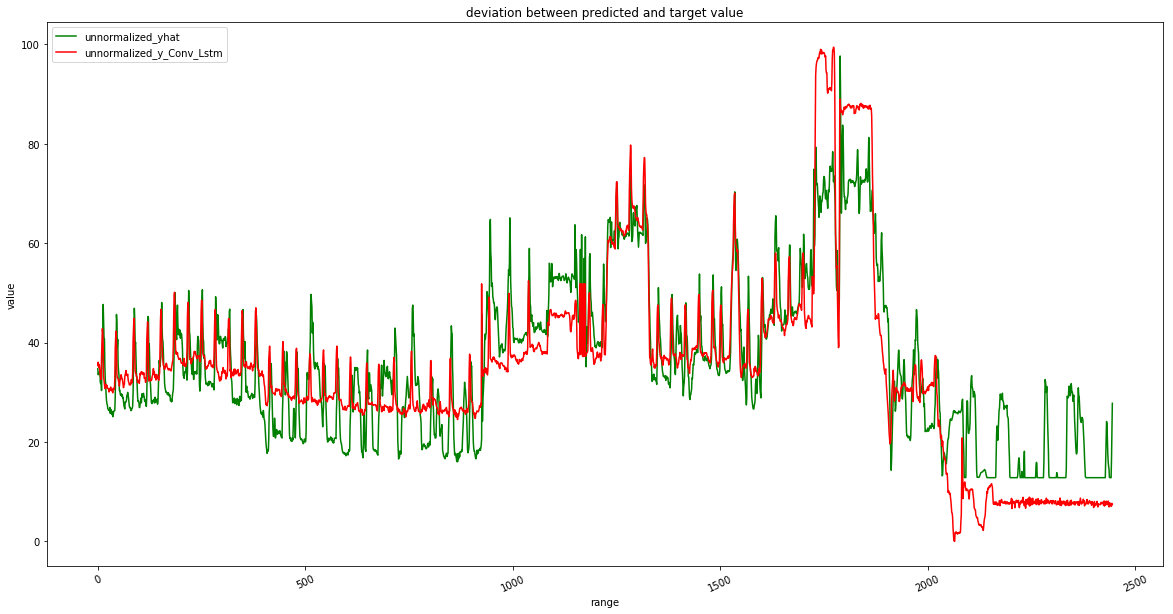

In [143]:
plt.plot(unnormalized_yhat,color='green')
plt.plot(unnormalized_y_Conv_Lstm_test,color='red')
plt.xticks( rotation=25)
plt.title('deviation between predicted and target value')
plt.ylabel('value')
plt.xlabel('range')
plt.legend(['unnormalized_yhat', 'unnormalized_y_Conv_Lstm'], loc='upper left')
plt.show()

In [144]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Print MSE to see how good the model is
Error = mean_squared_error(unnormalized_y_Conv_Lstm_test,unnormalized_yhat)
print('mean squared error: ',Error)
print('RMSE Error: ',sqrt(Error))

mean squared error:  82.37309937924178
RMSE Error:  9.075962724650305


In [173]:
# x=multivariate_data_mean.max()
# print(x[0])

67.61101867732815


In [204]:
# finding max value from each column
max_array=[]
i=0
for idx,val in enumerate(list(multivariate_data_mean.columns)):
    x=multivariate_data_mean[val].max()
    q=[val,x]
    max_array.append(q)
    
    

In [205]:
print(max_array[0][-1])

67.61101867732815


In [206]:
max_array=np.array(max_array)

In [207]:
print(max_array)

[['AEDATZ_HO_V0' '67.61101867732815']
 ['AEWIHO_T9AV2' '99.03705800931169']
 ['AEWIHOAVABV2' '96.347427549395']
 ['RWWIHOA_HWT0' '99.30801700284124']
 ['AEWIHOAKZ_V0' '92.0322826114535']
 ['RWWIHOA_MWT0' '99.51592757474876']
 ['AEDAHO_T9_V2' '99.4516393320581']]


In [201]:
test_new.head()

,row ID,longTime,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,...,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,stringTime,correct_longtime,dateTime
0,Row0,1555311120000,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,...,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000,2019-04-15 08:52,1555311120,2019-04-15 08:52:00
1,Row1,1555311060000,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,...,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890,2019-04-15 08:51,1555311060,2019-04-15 08:51:00
2,Row2,1555311000000,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,...,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735,2019-04-15 08:50,1555311000,2019-04-15 08:50:00
3,Row3,1555310940000,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,...,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882,2019-04-15 08:49,1555310940,2019-04-15 08:49:00
4,Row4,1555310880000,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,...,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317,2019-04-15 08:48,1555310880,2019-04-15 08:48:00


In [202]:
df = test.drop(test.columns[[0]], axis=1)

In [203]:
df.head()

,longTime,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,...,RWWIHOUT10V1,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0
0,1555311120000,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,57.766387,...,0.0,92.632593,44.620461,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000
1,1555311060000,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,58.231774,...,0.0,82.082055,53.182296,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890
2,1555311000000,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,58.231774,...,0.0,82.098144,53.029243,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735
3,1555310940000,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,58.231774,...,0.0,82.074011,53.015226,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882
4,1555310880000,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,58.697162,...,0.0,82.078296,53.172932,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317


In [210]:
# finding max value from each column
test_array=[]
i=0
for idx,val in enumerate(list(df.columns)):
    x=df[val].max()
    q=[val,x]
    test_array.append(q)
test_array=np.array(test_array)
print(test_array)
    

[['longTime' '1555311120000']
 ['AEAGHOAWE2T1' '98.67343689926952']
 ['AEAGHOAWE2A0' '100.0']
 ...
 ['RWWIHO_VERV0' '82.07662441475391']
 ['RWWIHO_UESV0' '24.143981819657487']
 ['RWWIHOSUMAV0' '80.343808413699']]


In [211]:
for i in test_array:
    print(i)

['longTime' '1555311120000']
['AEAGHOAWE2T1' '98.67343689926952']
['AEAGHOAWE2A0' '100.0']
['AEAGHOAWE2T0' '98.68047251105995']
['AEAGHOAWE1A0' '100.0']
['AEAGHOAWE1T1' '95.32436459606436']
['AEAGHOAWE1T0' '71.79520644194703']
['AEAGHOAWE3T0' '99.32869318959595']
['AEAGHOAWE3A0' '100.0']
['AEAGHOAWE3T1' '95.40444935956188']
['AEAGHOAWE_A2' '100.0']
['AEAGHOAWE_A1' '100.0']
['AEAGHOAWE_A0' '97.79370330347851']
['AEAGHOAWE_T3' '89.41684665226782']
['AEAGTHHPF2T0' '98.90628952682538']
['AEAGHOA_S2G0' '0.27899650081395344']
['AEAGHOAWE_T2' '94.91172570223551']
['AEAGHOAWE_T1' '97.35716108565063']
['AEAGHOB_GHA0' '94.87926780568053']
['AEAGHOB_GHT0' '97.93192589401121']
['AEAGHOBWE2T0' '99.12758236943931']
['AEAGHOBWE2A0' '100.0']
['AEAGHOBWE2T2' '100.0']
['AEAGHOBWE1T0' '98.249156936261']
['AEAGHOBWE1T2' '100.0']
['AEAGHOBWE1A0' '100.0']
['AEAGHOBWE3T0' '99.25435756395004']
['AEAGHOBWE3T2' '100.0']
['AEAGHOBWE3A0' '100.0']
['AEAGHOBWE_T1' '100.0']
['AEAGHOBWE_T2' '100.0']
['AEAGHOBWE_A1' '

['CAKGTZK_ASA2' '0.0']
['AEKGKOKA__V0' '99.26187047741013']
['AEKGKOKA__V1' '97.11379465130777']
['AEKGKOKB__V0' '97.35441388172129']
['AEKGKOKB__V1' '72.77822562523791']
['AEKGTWWOF3V0' '75.38320369924057']
['AEKGTWWOF4V0' '83.76606579230862']
['AEKGTWWMG5P0' '83.00824239180571']
['AEKGTWG_WKV0' '83.61074381432094']
['AEKGTWW_WKV0' '98.3927484108366']
['AEKGTWWH2SA3' '100.0']
['AEKGNETTEEP0' '79.41449737548828']
['AEKGTWWH2SA5' '100.0']
['AEKGTWWOF3V3' '89.24954590352783']
['AEKGTWWOF5V0' '95.57767904520044']
['AEKGTWWH2SA4' '100.0']
['AEKGTWWOF4V3' '89.42848974041597']
['AEKGTWWOF5V3' '99.99197771132091']
['AEKGTWG_WKV2' '68.54405140943307']
['AEKGTWWOF6V0' '87.53282775669321']
['AEKGTWWMG6P0' '99.5271342393751']
['AEKGTWWH2SA6' '100.0']
['AEKGTWWOF6V3' '100.0']
['CAKGTWWH2SA5' '0.0']
['CAKGTWWH2SA0' '0.0']
['CAKGTWWOF3V0' '0.0']
['CAKGTWWOF4V0' '0.0']
['CAKGTWWOF5V0' '0.0']
['CAKGTWWOF6V0' '0.0']
['CAKGTWWH2SA6' '0.0']
['AEKGF_C___V0' '100.0']
['AEKGTWGB31V1' '100.0']
['AEKGTWGB32V1

['DEKDTK_KDZN1' '100.0']
['DEKDHK_TSBA1' '0.0']
['DEKDHK_WW3A1' '10.0']
['DEKDHK_WW1A1' '100.0']
['DEKDHK_KDZN1' '89.55223880597015']
['DEKDHK_KDZN2' '100.0']
['DEWAR40Y5MI0' '0.0']
['DEWAR40Y6MI0' '0.0']
['DEKDHK_KDZB1' '0.0']
['DEKDHK_TSBA2' '89.55223880597015']
['DEKDHK_KDZS4' '0.0']
['DEKDHK_KDZB4' '89.55223880597015']
['DEKDHK_KDZS3' '89.55223880597015']
['DEKDHK_KDZB3' '0.0']
['DEKDHK_KDZS2' '89.55223880597015']
['DEKDHK_KDZB2' '0.0']
['DEKDHK_KDZS1' '89.55223880597015']
['DEKDHK_TSBG0' '100.0']
['DEKDHK_WW1G0' '100.0']
['DEKDHK_WW3G0' '89.55223880597015']
['DEKDHK_WW1A2' '0.0']
['DEKDHK_WW3A2' '0.0']
['DEKDHK_WW1G1' '89.55223880597015']
['DEKDHK_WW3G1' '0.0']
['DEKDHK_TSBG1' '89.55223880597015']
['DEWASGGPSTN4' '0.0']
['DEWASGGPSTN3' '100.0']
['DEWASGGPSTN2' '0.0']
['DEWASGGPSTN1' '0.0']
['DEWASGGP2PI0' '100.0']
['DEWASGGP_VG1' '100.0']
['DEWASGGP_AG1' '89.55223880597015']
['DEWASGGP_EG1' '100.0']
['DEWASGGP_SG1' '0.0']
['DEWASGGHA2P2' '0.0']
['DEWASGGHA2P1' '0.0']
['DEWASGGHA2T